# Introduction

In [ ]:
from google.colab import files

In [ ]:
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install -q kaggle

In [2]:
!kaggle datasets list -s amazon

ref                                                    title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
snap/amazon-fine-food-reviews                          Amazon Fine Food Reviews                     242MB  2017-05-01 18:51:31         125092       1892  0.7941176        
kritanjalijain/amazon-reviews                          Amazon reviews                                 1GB  2021-05-15 09:45:40           3824         63  1.0              
sid321axn/amazon-alexa-reviews                         Amazon Alexa Reviews                         164KB  2018-07-31 17:45:14          16425        242  0.8235294        
eswarchandt/amazon-music-reviews                       Amazon Musical Instruments Reviews             5MB  2020-03-29 02:59:52          1084

In [3]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

100%|███████████████████████████████████████▉| 242M/242M [00:11<00:00, 25.4MB/s]
100%|████████████████████████████████████████| 242M/242M [00:11<00:00, 21.2MB/s]


In [4]:
!mkdir -p data/amazon
!unzip amazon-fine-food-reviews.zip -d data/amazon

Archive:  amazon-fine-food-reviews.zip
  inflating: data/amazon/Reviews.csv  
  inflating: data/amazon/database.sqlite  
  inflating: data/amazon/hashes.txt  


In [2]:
import pandas as pd
#load the data
sample=pd.read_csv("data/amazon/Reviews.csv")

In [3]:
sample = sample.groupby('Score', group_keys=False).apply(lambda x: x.sample(frac=0.1))

In [4]:
#check the loaded data
print(sample.shape)

(56846, 10)


In [5]:
#look of the dataset
sample.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
469677,469678,B007ZHMJC8,A2V1RP71UH9MH0,"Andrew J. Griffin ""Andrew""",1,1,1,1350518400,This stuff is nasty,"After a solid early morning workout, I was loo..."
567828,567829,B005K4Q68Q,A1P1BJMLJYJCR2,Nikki,0,1,1,1325894400,Taste like diet,"I ordered this specifically b/c they said ""dar..."
533718,533719,B0009DY554,A1NYKD19R5JQWD,Rayne,0,0,1,1333584000,really disappointed,"though i did not purchase this through amazon,..."
205902,205903,B0029JZLWW,A1R9SKERZWSO2T,Lyn Robie,1,5,1,1330819200,Yuck,Tastes like a rancid dishrag pickled in brine....
241257,241258,B000HIFB8Q,A1XXB8WV8XYNKO,Kumar,1,6,1,1323734400,Loaded with sugar and sodium,Its very tasty but check the nutritional facts...


/home/bruno/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Score', ylabel='count'>

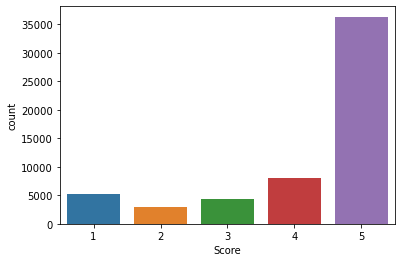

In [6]:
# Understand how customer ratings are distributed
import seaborn as sns
sns.countplot(sample.Score)

 # Data Cleaning

In [7]:
#converting the Numerical reviws to categorical reviews on codition above 3 are
#positive and below 3 are negative as reviews rating with 3 are not much useful
#for analysis

#function
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive
actualScore = sample['Score']
positiveNegative = actualScore.map(partition) 
sample['Score'] = positiveNegative

In [8]:
sample.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
469677,469678,B007ZHMJC8,A2V1RP71UH9MH0,"Andrew J. Griffin ""Andrew""",1,1,negative,1350518400,This stuff is nasty,"After a solid early morning workout, I was loo..."
567828,567829,B005K4Q68Q,A1P1BJMLJYJCR2,Nikki,0,1,negative,1325894400,Taste like diet,"I ordered this specifically b/c they said ""dar..."
533718,533719,B0009DY554,A1NYKD19R5JQWD,Rayne,0,0,negative,1333584000,really disappointed,"though i did not purchase this through amazon,..."
205902,205903,B0029JZLWW,A1R9SKERZWSO2T,Lyn Robie,1,5,negative,1330819200,Yuck,Tastes like a rancid dishrag pickled in brine....
241257,241258,B000HIFB8Q,A1XXB8WV8XYNKO,Kumar,1,6,negative,1323734400,Loaded with sugar and sodium,Its very tasty but check the nutritional facts...


In [9]:
# no of positive and negative reviews
sample["Score"].value_counts()
#here we can say it is a unbalanced data set

positive    48642
negative     8204
Name: Score, dtype: int64

In [10]:
#dropping  the duplicates column if any using drop duplicates from pandas
sorted_data=sample.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape


(52041, 10)

In [11]:
# no duplicate columns found
(final['Id'].size*1.0)/(sample['Id'].size*1.0)*100

91.54733842310804

In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
# Help..Num is always less than Denom.. as Denom is people who upvote and donwvote
#Before understanding text preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

# after removing duplicate rows we found, 8346 positive and 1457 negative

(52041, 10)


positive    44526
negative     7515
Name: Score, dtype: int64

/home/bruno/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Score', ylabel='count'>

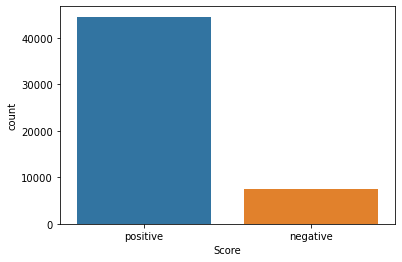

In [13]:
# After Removing Duplicate rows
import seaborn as sns
sns.countplot(final.Score)

# Text Processing

To make the text clean by removing HTML tag reviews, stopwords to segregate and adding timestamp

In [14]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

1
These days, when a person says, "chicken soup" they're probably going to follow up those words with, "for the soul" or maybe "for the teenaged soul".  Didn't used to be that way.  Why I can remember a time when if a person said, "chicken soup" those words were followed by an enthusiastic "with rice!".  Such was the power of Maurice Sendak's catchy 1962 children's book.  I am pleased to report that if you care to read this book again today, you will find it hasn't dimished a jot in terms of frolicksome fun.  In this book we are led through a whirlwind chicken soup year with our host, a boy who bears no little resemblance to Sendak's other great rhyming tale "Pierre" (in looks if not demeanor).  It's a catchy flouncy bouncy combo of soup and the people who love it so.<br /><br />This is ostensibly a book meant to teach your children the different months of the year.  Each month gets its own rhythmic poem and accompanying illustration.  These are fairly simple pen and ink drawings with 

In [15]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer which is developed in recent years
stop=set(stopwords.words('english'))

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'more', 'mustn', 'off', 'are', 'until', 'she', 'below', 'will', 'into', 'him', 'the', 'further', 'our', 'each', 'too', 'against', 'does', 're', 'been', 'for', 'now', "hasn't", 'on', 'did', 'being', 'o', 'here', 'll', 'ma', "aren't", 'from', 'and', 'your', 'doesn', 'they', 'you', "wouldn't", "couldn't", 'just', 'then', 'but', 'down', 'again', 'isn', "hadn't", 'them', 'some', 'over', 'while', 'only', 'a', 'up', 'ourselves', 'whom', 'why', "weren't", 'any', "shouldn't", 'what', 'during', 'theirs', 'same', 'should', 'when', 'yours', 'before', 'which', "you've", 'of', 'where', "mightn't", 'weren', "it's", 't', 'at', 'after', 'he', 'doing', 'as', 'few', 'am', "won't", 'there', 'himself', 'do', 'his', 'because', 'above', "didn't", 'were', 'd', 'hadn', 'between', 'wouldn', 'myself', 's', 've', 'have', 'or', 'hers', "haven't", 'wasn', "she's", 'we', 'didn', 'those', 'its', 'these', 'can', "mustn't", 'mightn', "needn't", 'to', 'other', 'i', 'my', 'by', "doesn't", "should've", 'this', 'about', '

[nltk_data] Downloading package stopwords to /home/bruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
from tqdm import tqdm

In [17]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in tqdm(final['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

100%|███████████████████████████████████| 52041/52041 [00:34<00:00, 1487.30it/s]


In [18]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [19]:
final.shape 

(52041, 11)

In [20]:
data_pos = final[final["Score"] == "positive"]
data_neg = final[final["Score"] == "negative"]
final = pd.concat([data_pos, data_neg])
score =final["Score"]
final.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
150527,150528,0006641040,AGQWHPNDZGUD0,Bolt81,0,1,positive,1296864000,Size does matter,This book was purchased to be used in a classr...,book purchas use classroom set purpos small si...
150492,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,positive,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""...",day person say chicken soup theyr probabl go f...
150509,150510,0006641040,AM1MNZMYMS7D8,Dr. Joshua Grossman,0,0,positive,1348358400,Professional Mentoring,TITLE: Chicken Soup with Rice<br />AUTHOR: Mau...,chicken soup rice mauric sendak josh grossman ...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
150501,150502,0006641040,AVFMJ50HNO21J,Jane Doe,1,1,positive,1324944000,"Tiny little book, Wonderful little rhymes.",This copy is smaller than I expected (mostly b...,copi smaller expect most didnt pay attent list...


In [21]:

final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final= final.sort_values(by = "Time")
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
374421,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,2000-01-09,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
374449,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happen say name three time michael keaten star...
230333,230334,B00004RYGX,A1GB1Q193DNFGR,Bruce Lee Pullen,5,5,positive,2000-10-03,Fabulous Comedic Fanasy Directed by a Master,Beetlejuice is an awe-inspiring wonderfully am...,beetlejuic wonder amus comed romp explor incre...
149767,149768,B00004S1C5,A7P76IGRZZBFJ,"E. Thompson ""Soooooper Genius""",18,18,positive,2000-12-05,Who Needs Wilton?,I'm sick of scads of nasty toothpicks all over...,sick scad nasti toothpick counter tint concept...
230308,230309,B00004RYGX,A34NBH479RB0E,"""dmab6395""",0,1,positive,2000-12-19,FUNNY,"I THOUGHT THIS MOVIE WAS SO FUNNY, MICHAEL KEA...",thought movi funni michael keaton beetlejuic r...


#  Clustering


### K means using bag of words

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
bow = tfidf_vect.fit_transform(final['CleanedText'].values)
bow.shape

(52041, 27154)

In [23]:
bow

<52041x27154 sparse matrix of type '<class 'numpy.float64'>'
	with 1643655 stored elements in Compressed Sparse Row format>

In [24]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters = 10,init='k-means++',random_state=99)
model.fit(bow)

KMeans(n_clusters=10, random_state=99)

In [25]:
df = final
df["Tfidf Clus Label"] = model.labels_ # the last column you can see the label numebers
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Tfidf Clus Label
374421,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,2000-01-09,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...,5
374449,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happen say name three time michael keaten star...,5


In [26]:
# visually how points or reviews are distributed across 10 clusters 
import matplotlib.pyplot as plt

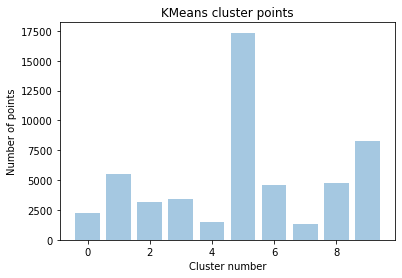

In [27]:
plt.bar([x for x in range(10)], df.groupby(['Tfidf Clus Label'])['Text'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

In [28]:
df.groupby(['Tfidf Clus Label'])['Text'].count()

Tfidf Clus Label
0     2219
1     5514
2     3189
3     3431
4     1503
5    17354
6     4558
7     1290
8     4733
9     8250
Name: Text, dtype: int64

# Average Word to Vector

In [29]:
final.shape

(52041, 12)

In [30]:
# final = final.groupby('Score', group_keys=False).apply(lambda x: x.sample(frac=0.1))

In [31]:
final = final.sample(frac=1/10)

In [32]:
final.shape

(5204, 12)

In [33]:
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [34]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

made first cup ad cream sugar sure expect like drink sugar began drink still sweet finish order order
*****************************************************************
['made', 'first', 'cup', 'ad', 'cream', 'sugar', 'sure', 'expect', 'like', 'drink', 'sugar', 'began', 'drink', 'still', 'sweet', 'finish', 'order', 'order']


In [35]:
i=0
list_of_sent_train=[]
for sent in final['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

In [36]:
import gensim
import fasttext
w2v_model=gensim.models.Word2Vec(list_of_sent_train,vector_size=100, workers=4)

In [37]:
import numpy as np
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this train
for sent in tqdm(list_of_sent_train): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.array(sent_vectors)
sent_vectors = np.nan_to_num(sent_vectors)
sent_vectors.shape


100%|█████████████████████████████████████| 5204/5204 [00:00<00:00, 9741.17it/s]


(5204, 100)

In [38]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
distance_array = pairwise_distances(sent_vectors, metric='cosine')

In [39]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.6, min_samples=20).fit(distance_array)

In [40]:
clustering.labels_


array([ 0, -1, -1, ...,  0,  0,  0])

In [41]:
final['w2v_Clus_Label'] = clustering.labels_ # the last column you can see the label numebers
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Tfidf Clus Label,w2v_Clus_Label
489067,489068,B005K4Q1YA,A3SXS9LD4ZN5P5,"Scwest68 ""Scwest""",0,1,positive,2011-12-12,Too sweet!,When I made my first cup I added cream and sug...,made first cup ad cream sugar sure expect like...,9,0
1675,1676,B001RVFDOO,A107MO1RZUQ8V,Italian Girl,0,0,positive,2010-12-10,Yum,That's all I can say. Yum at a great price! I ...,that say yum great price cant find size anywhe...,8,-1


In [42]:
final.groupby(['w2v_Clus_Label'])['CleanedText'].count()

w2v_Clus_Label
-1     946
 0    4258
Name: CleanedText, dtype: int64

In [63]:
final[final['w2v_Clus_Label'] == -1]["CleanedText"].values

array(['that say yum great price cant find size anywher local groceri awesom',
       'anyon still think decaf coffe mean sanka crystal miss good flavor coffe without caffein enjoy drink sever cup coffe day caffein make edgi balanc regular blend coffe decaf like green mountain extra bold still plenti robust coffe flavor caffein high recommend',
       'tea arriv promis enjoy ice tea warm cup breakfast pleas product price',
       'best flavor coffe senseo ive tri price hike flavor',
       'dog eat bench field dog food use treat love much never eat cheap filler dog bone month old larg dog slim perfect said vet healthi beauti coat cost littl dont want dog eat garbag filler product know stuff',
       'pleas find item abl purchas abl find store favorit crystal light drink',
       'can food real chunk chicken dog love look smell better can beef stew like dinti moor',
       'glad flavor woould gain pound great chocol flavor smooth drink',
       'gloria jean butter toffe satisfi sever se

In [64]:
final[final['w2v_Clus_Label'] == 0]["CleanedText"].values

array(['made first cup ad cream sugar sure expect like drink sugar began drink still sweet finish order order',
       'dont get wrong add nice flavor water price per ounc outrag mango peach requir quit squeez get good flavor bottl water will tri flavor doubt buy flavor big fan one dont want water faint flavor rather plain water use much flavor get good tast water',
       'fair larg pack cannist cbtl chocol powder never much cbtl great make mocha hot chocol cbtl also recip morrocan tea latt stir bit choco powder brew morrocan mint tea top latt froth yummmm chocol rich delish',
       ...,
       'blown away delici tin cod liver bay pepper special touch realli enjoy toast slice rustic bread drizzl oliv oil spoon cod liver onto sprinkl toast seawe delici king oscar cod liver oil tin pack',
       'kind disappoint blend tea bit bland intens bad thing howev flavor pretti bland weak well ive found tazo full leaf tea bag use starbuck earl grey best flavor intens part design milk tea latt do

In [65]:
final[final['w2v_Clus_Label']== -1]["Score"].value_counts()

positive    840
negative    106
Name: Score, dtype: int64

In [66]:
final[final['w2v_Clus_Label'] == 0]["Score"].value_counts()

positive    3595
negative     663
Name: Score, dtype: int64

In [67]:

from sklearn.decomposition import PCA
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(sent_vectors)
PCA_ds = pd.DataFrame(pca.transform(sent_vectors), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,5204.0,-7.123433e-17,0.542082,-2.047682,-0.341175,-0.003094,0.360736,2.130861
col2,5204.0,-2.377465e-16,0.412659,-1.932812,-0.256839,-0.043834,0.235629,2.267610
col3,5204.0,1.405198e-15,0.179993,-0.786009,-0.110656,0.001640,0.112341,1.554174


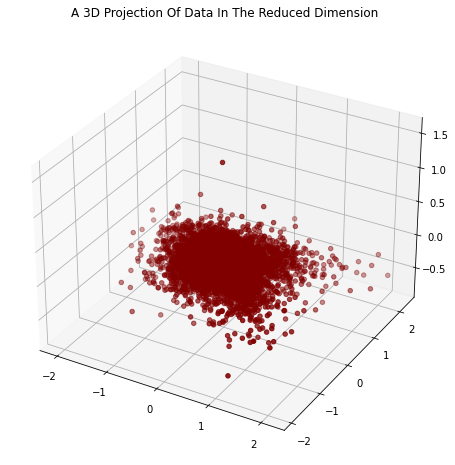

In [48]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

In [49]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.6, min_samples=2)
yhat_AC = clustering.fit_predict(sent_vectors)
PCA_ds["Clusters_DBSCAN"] = yhat_AC

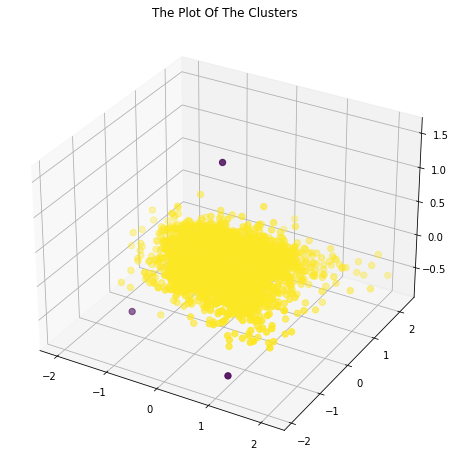

In [50]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters_DBSCAN"], marker='o')
ax.set_title("The Plot Of The Clusters")
plt.show()

/home/bruno/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


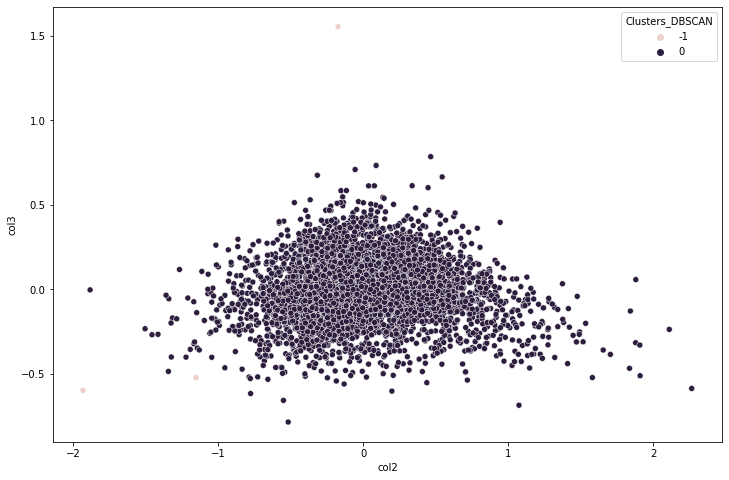

In [51]:
plt.figure(figsize=(12, 8))
sns.scatterplot(PCA_ds['col2'], PCA_ds['col3'], hue=PCA_ds["Clusters_DBSCAN"])
plt.show()

In [52]:
import fasttext
from tqdm import tqdm

## Fasttext

In [53]:
model = fasttext.load_model("models/cc.en.300.bin")

In [54]:
import numpy as np
sent_vectors_fasttext = []; # the avg-w2v for each sentence/review is stored in this train
for sent in tqdm(list_of_sent_train): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    sent_vec = model.get_sentence_vector(str(sent))
    sent_vectors_fasttext.append(sent_vec)
    
sent_vectors_fasttext = np.array(sent_vectors_fasttext)
sent_vectors_fasttext.shape


100%|█████████████████████████████████████| 5204/5204 [00:00<00:00, 7618.34it/s]


(5204, 300)

In [55]:

from sklearn.decomposition import PCA
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(sent_vectors_fasttext)
PCA_ds = pd.DataFrame(pca.transform(sent_vectors_fasttext), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,5204.0,1.331483e-09,0.044360,-0.187780,-0.028601,-0.002277,0.026338,0.242465
col2,5204.0,-1.069482e-08,0.037573,-0.154061,-0.022634,-0.000147,0.023728,0.193651
col3,5204.0,1.962077e-08,0.034696,-0.146679,-0.020288,-0.000601,0.019473,0.208150


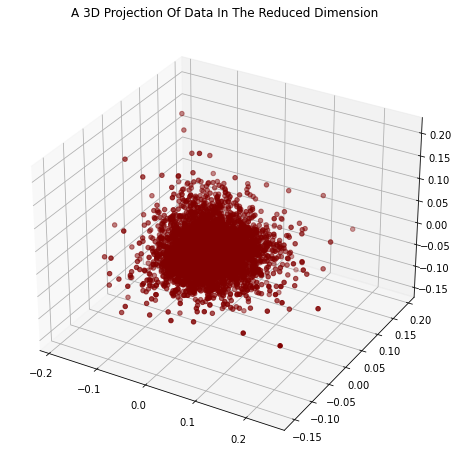

In [56]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

In [57]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.6, min_samples=2)
yhat_AC = clustering.fit_predict(sent_vectors_fasttext)
PCA_ds["fasttext_Clusters_DBSCAN"] = yhat_AC

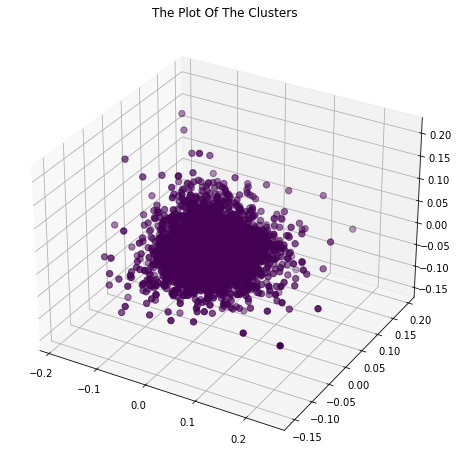

In [58]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["fasttext_Clusters_DBSCAN"], marker='o')
ax.set_title("The Plot Of The Clusters")
plt.show()

In [60]:
import hdbscan

In [61]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=30, gen_min_span_tree=True)
clusterer.fit(sent_vectors_fasttext)

HDBSCAN(gen_min_span_tree=True, min_cluster_size=30)

/home/bruno/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/bruno/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

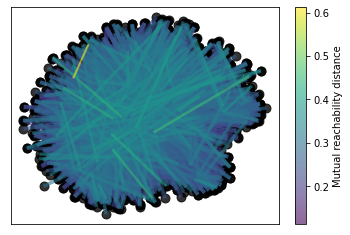

In [62]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)